In [2]:
import sys
import numpy as np
import math
import random
import matplotlib
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from scipy.stats import entropy
from scipy.special import logsumexp,softmax

import gym
import gym_maze

import pdb

def simulate():
    # stats
    EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])
    stats = EpisodeStats(episode_lengths = np.zeros(NUM_EPISODES), episode_rewards = np.zeros(NUM_EPISODES))    
    # Instantiating the learning related parameters
    learning_rate = 1
    explore_rate = get_explore_rate(0)
    discount_factor = 0.99

    num_streaks = 0

    # Render tha maze
    env.render()

    for episode in range(NUM_EPISODES):

        # Reset the environment
        obv = env.reset()

        # the initial state
        state_0 = state_to_bucket(obv)
        total_reward = 0

        for t in range(MAX_T):

            # Select an action
            policy = softmax(q_table[state_0]/REWARD_SCALE)
            #pdb.set_trace()
            action = select_action(policy, episode)

            # execute the action
            obv, reward, done, _ = env.step(action)
            reward = reward*real_reward_scale

            # Observe the result
            state = state_to_bucket(obv)
            total_reward += reward

            # Update the Q based on the result
            q_table_0 = q_table.copy()
            q_table_backup = q_table.copy()
            v_next = REWARD_SCALE*logsumexp(q_table_0[state] / REWARD_SCALE)
            td_error = reward + discount_factor * (v_next) - q_table[state_0 + (action,)]
            #pdb.set_trace()
            q_table_backup[state_0 + (action,)] += td_error
            policy_new = softmax(q_table_backup[state_0]/REWARD_SCALE)
            q_table[state_0 + (action,)] += learning_rate * td_error
            v_old = REWARD_SCALE*logsumexp(q_table_0[state_0]/REWARD_SCALE)
            v_new = REWARD_SCALE*logsumexp(q_table_backup[state_0]/REWARD_SCALE)
            td_errors.append(np.max([policy_new[action], policy[action]])*td_error)
            eves.append(v_new - v_old)
            value_ivs.append(np.sum(policy*(q_table_backup[state_0] - q_table_0[state_0])))
            policy_ivs.append(v_new - v_old - policy[action]*td_error)
            # Setting up for the next iteration
            state_0 = state

            # Print data
            if DEBUG_MODE == 2:
                print("\nEpisode = %d" % episode)
                print("t = %d" % t)
                print("Action: %d" % action)
                print("State: %s" % str(state))
                print("Reward: %f" % reward)
                print("Best Q: %f" % best_q)
                print("Explore rate: %f" % explore_rate)
                print("Learning rate: %f" % learning_rate)
                print("Streaks: %d" % num_streaks)
                print("")

            elif DEBUG_MODE == 1:
                if done or t >= MAX_T - 1:
                    print("\nEpisode = %d" % episode)
                    print("t = %d" % t)
                    print("Explore rate: %f" % explore_rate)
                    print("Learning rate: %f" % learning_rate)
                    print("Streaks: %d" % num_streaks)
                    print("Total reward: %f" % total_reward)
                    print("")

            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()

            if done:
                print(q_table)
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (episode, t, total_reward, num_streaks))

                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (episode, t, total_reward))
        
        stats.episode_lengths[episode] = t
        stats.episode_rewards[episode] = total_reward

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
    return(stats)


def select_action(policy, episode):
    if episode <5:
        action = env.action_space.sample()
    else:
        # Select a random action (when epsilon probability and q_value are the same in that state)
        action = int(np.random.choice(np.arange(NUM_ACTIONS), p = policy))
    return action


def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(1, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(1, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)


if __name__ == "__main__":

    # Initialize the "maze" environment
    env = gym.make("maze-sample-5x5-v0").unwrapped

    '''
    Defining the environment related constants
    '''
    # Number of discrete states (bucket) per state dimension
    MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
    NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

    # Number of discrete actions
    NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
    # Bounds for each discrete state
    STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

    '''
    Learning related constants
    '''
    MIN_EXPLORE_RATE = 0.001
    MIN_LEARNING_RATE = .1
    DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0
    REWARD_SCALE = 1/100
    real_reward_scale = 1
    '''
    Defining the simulation related constants
    '''
    NUM_EPISODES = 50
    MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
    STREAK_TO_END = 50
    SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
    DEBUG_MODE = 0
    RENDER_MAZE = True
    ENABLE_RECORDING = True
    
    '''
    Creating a Q-Table for each state-action pair
    '''
    q_table = np.random.rand(NUM_BUCKETS[0], NUM_BUCKETS[1], NUM_ACTIONS)
    policy_table= np.random.rand(NUM_BUCKETS[0], NUM_BUCKETS[1], NUM_ACTIONS)
    '''
    Begin simulation
    '''
    recording_folder = "/tmp/maze_q_learning"
    
    # Recordings
    policy_ivs = []
    value_ivs = []
    eves = []
    td_errors = []

    stats_recorded = simulate()
    env.close()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
[[[0.97476112 0.37620873 0.46278284 0.73675975]
  [0.26984027 0.9393936  0.08383165 0.29401416]
  [0.08634215 0.63101949 0.04945113 0.67279852]
  [0.94134942 0.94235786 0.93906231 0.94139699]
  [0.94142212 0.9423066  0.94232096 0.94225481]]

 [[0.43566341 0.09640102 0.69356804 0.47121609]
  [0.51529536 0.51139605 0.26590104 0.85362563]
  [0.27086932 0.16909339 0.94547921 0.53386981]
  [0.93883488 0.93504704 0.93876853 0.94139699]
  [0.93897665 0.93508113 0.92915076 0.93451534]]

 [[0.61745236 0.68162364 0.5453306  0.68159882]
  [0.69252382 0.9027124  0.69141546 0.69304077]
  [0.69141546 0.92064772 0.91326224 0.91296049]
  [0.91383468 0.92858701 0.9195529  0.91943555]
  [0.9219811  0.92897503 0.92309448 0.93536596]]

 [[0.05012039 0.7536149  0.28100189 0.94508978]
  [0.87925773 0.88448251 0.86500514 0.87989024]
  [0.87907961 0.91825668 0.90278013 0.88274936]
  [0.90732865 0.92378209 0.91714501 0.917657 

[[[1.44468962 1.44475437 1.4600788  1.44391395]
  [0.95454304 0.95394211 0.95455293 0.95450133]
  [0.95454304 0.95365345 0.95349685 0.95387106]
  [1.4924617  1.47944496 1.50757355 1.49246175]
  [1.49246174 1.47944481 1.47944482 1.47944481]]

 [[1.4600788  1.42359185 1.47730826 1.44468962]
  [1.45697982 0.95339369 1.42042685 1.42188772]
  [1.42334659 0.95312255 0.95339369 0.95388405]
  [1.50757355 1.52600017 1.50758564 1.49246175]
  [1.50758564 1.52600017 1.5422754  1.52623307]]

 [[1.47581984 1.49275076 1.47716994 1.45682383]
  [1.47478401 1.50926375 1.49070776 1.49275076]
  [1.49100124 1.52560169 1.50746768 1.50747425]
  [1.50734893 1.54235687 1.52295414 1.52295466]
  [1.52293404 1.54196554 1.56004901 1.52623307]]

 [[1.59487137 1.59484752 1.60993409 1.59484234]
  [1.60964991 1.59226853 1.62693596 1.60974014]
  [1.60991168 1.57583003 1.59227056 1.59305968]
  [1.59296919 1.55959801 1.57635728 1.57629563]
  [1.57646323 1.55985002 1.55995089 1.54190962]]

 [[1.60993409 1.62682272 1.60993

  [0.34722493 0.45859571 0.68758069 0.002693  ]]]
Episode 15 finished after 19.000000 time steps with total reward = 0.924000 (streak 10).
[[[1.44468962 1.44475437 1.46149944 1.44695403]
  [0.95454304 0.95394211 0.95455293 0.95450133]
  [0.95454304 0.95365345 0.95349685 0.95387106]
  [1.4924617  1.47944496 1.50757355 1.49246175]
  [1.49246174 1.47944481 1.47944482 1.47944481]]

 [[1.46125313 1.42359185 1.47872084 1.44468962]
  [1.45697982 0.95339369 1.42042685 1.42188772]
  [1.42334659 0.95312255 0.95339369 0.95388405]
  [1.50757355 1.52600017 1.50758564 1.49246175]
  [1.50758564 1.52640514 1.5427009  1.52638398]]

 [[1.47751228 1.4942418  1.47830967 1.45682383]
  [1.47478401 1.51053888 1.49070776 1.49275076]
  [1.49100124 1.52641709 1.51034851 1.50974128]
  [1.5103957  1.54272055 1.52631251 1.52295466]
  [1.52293404 1.54267899 1.56037096 1.52638398]]

 [[1.59487137 1.59484752 1.60993409 1.59484234]
  [1.60996545 1.59226853 1.62695614 1.60974014]
  [1.60996545 1.57583003 1.59320497 1.5

[[[1.44860356 1.44475437 1.46206371 1.44828614]
  [0.95454304 0.95394211 0.95455293 0.95450133]
  [0.95454304 0.95365345 0.95349685 0.95387106]
  [1.4924617  1.47944496 1.50757355 1.49246175]
  [1.49246174 1.47944481 1.47944482 1.47944481]]

 [[1.46125313 1.42359185 1.47900345 1.44468962]
  [1.45697982 0.95339369 1.42042685 1.42188772]
  [1.42334659 0.95312255 0.95339369 0.95388405]
  [1.50757355 1.52600017 1.50758564 1.49246175]
  [1.50758564 1.52640514 1.5427009  1.52638398]]

 [[1.47900631 1.49458523 1.47900345 1.45682383]
  [1.47478401 1.51093496 1.49070776 1.49458523]
  [1.49452313 1.52656601 1.51034851 1.51093496]
  [1.5103957  1.54288466 1.52656601 1.52295466]
  [1.52293404 1.54267899 1.56049779 1.52638398]]

 [[1.59487137 1.59484752 1.60993409 1.59484234]
  [1.61002264 1.59226853 1.62698227 1.60998026]
  [1.61001758 1.57583003 1.59320497 1.59326199]
  [1.5932911  1.56049247 1.57677259 1.57683657]
  [1.5767622  1.56040838 1.56049779 1.5428941 ]]

 [[1.60993409 1.62693617 1.60993

[[[1.44860356 1.4491581  1.46294137 1.44828614]
  [0.95454304 0.95394211 0.95455293 0.95450133]
  [0.95454304 0.95365345 0.95349685 0.95387106]
  [1.4924617  1.47944496 1.50757355 1.49246175]
  [1.49246174 1.47944481 1.47944482 1.47944481]]

 [[1.46280808 1.42359185 1.48020194 1.44468962]
  [1.45697982 0.95339369 1.42042685 1.42188772]
  [1.42334659 0.95312255 0.95339369 0.95388405]
  [1.50757355 1.52600017 1.50758564 1.49246175]
  [1.50758564 1.52640514 1.5427009  1.52638398]]

 [[1.48020194 1.49562157 1.48027481 1.45682383]
  [1.47954169 1.51120902 1.49506171 1.49458523]
  [1.494853   1.52671192 1.51109436 1.51117767]
  [1.51097757 1.54310792 1.52656601 1.52295466]
  [1.52664155 1.54309807 1.56059254 1.52638398]]

 [[1.59487137 1.59484752 1.60993409 1.59484234]
  [1.61002424 1.59331013 1.62698545 1.60998026]
  [1.61004972 1.57583003 1.59333649 1.59334009]
  [1.59334009 1.56049247 1.57687369 1.57685695]
  [1.57687369 1.56040838 1.56056097 1.54304784]]

 [[1.60993409 1.62693617 1.60993

[[[1.45005198 1.45034102 1.46344363 1.44828614]
  [0.95454304 0.95394211 0.95455293 0.95450133]
  [0.95454304 0.95365345 0.95349685 0.95387106]
  [1.4924617  1.47944496 1.50757355 1.49246175]
  [1.49246174 1.47944481 1.47944482 1.47944481]]

 [[1.46280808 1.42359185 1.48043094 1.44468962]
  [1.45697982 0.95339369 1.42042685 1.42188772]
  [1.42334659 0.95312255 0.95339369 0.95388405]
  [1.50757355 1.52600017 1.50758564 1.49246175]
  [1.50758564 1.52640514 1.5431271  1.52638398]]

 [[1.48043094 1.49567672 1.48043336 1.45682383]
  [1.47954169 1.51125738 1.49506171 1.49458523]
  [1.494853   1.52722541 1.51125738 1.51117767]
  [1.51097757 1.54314956 1.52656601 1.5267831 ]
  [1.52664155 1.54309807 1.56063109 1.52675558]]

 [[1.59487137 1.59484752 1.60993409 1.59484234]
  [1.61006698 1.59331013 1.62699451 1.61005323]
  [1.61006698 1.57583003 1.5933527  1.59334184]
  [1.5933527  1.56062104 1.57692006 1.57692034]
  [1.57692006 1.56040838 1.56061536 1.54304784]]

 [[1.60993409 1.62693617 1.60993

[[[1.45082459 1.45102465 1.46376349 1.4510381 ]
  [0.95454304 0.95394211 0.95455293 0.95450133]
  [0.95454304 0.95365345 0.95349685 0.95387106]
  [1.4924617  1.47944496 1.50757355 1.49246175]
  [1.49246174 1.47944481 1.47944482 1.47944481]]

 [[1.46376349 1.42359185 1.48070986 1.44468962]
  [1.45697982 0.95339369 1.42042685 1.42188772]
  [1.42334659 0.95312255 0.95339369 0.95388405]
  [1.50757355 1.52600017 1.50758564 1.49246175]
  [1.50758564 1.52640514 1.5431271  1.52638398]]

 [[1.48043094 1.49607243 1.48043336 1.45682383]
  [1.47954169 1.51163074 1.49607243 1.49458523]
  [1.494853   1.52729673 1.51125738 1.51117767]
  [1.51097757 1.54318847 1.52656601 1.52723181]
  [1.52664155 1.54309807 1.56067081 1.52675558]]

 [[1.59487137 1.59484752 1.60993409 1.59484234]
  [1.61007208 1.59331013 1.62699824 1.61007274]
  [1.61007691 1.57583003 1.59336138 1.59334184]
  [1.59336435 1.56063843 1.57692006 1.57693041]
  [1.57693251 1.56063843 1.56061536 1.54304784]]

 [[1.60993409 1.62693617 1.60993

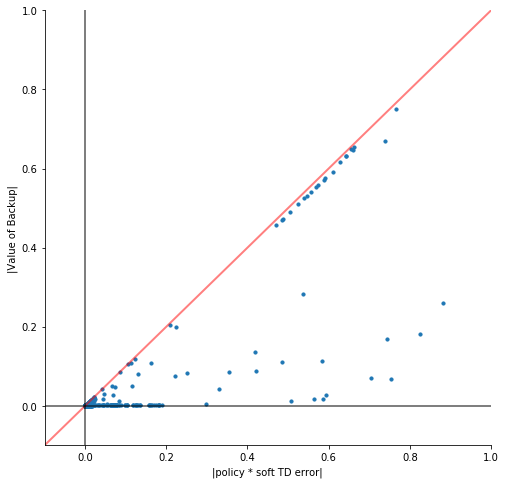

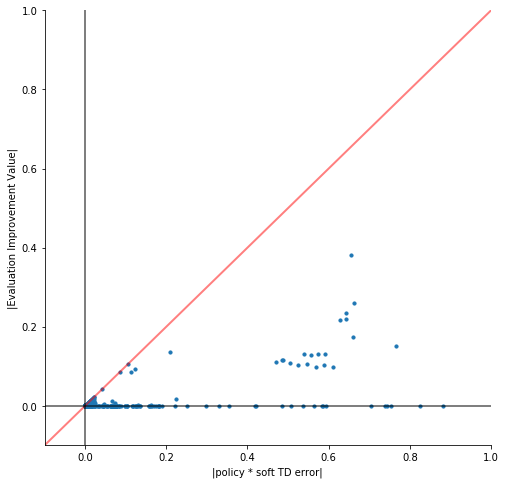

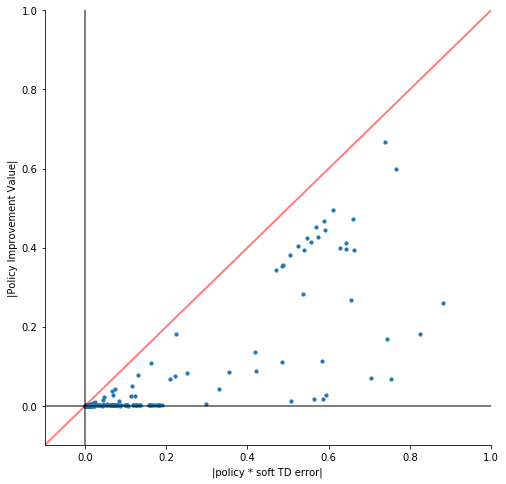

In [19]:
plt.figure()
plotlim = 1
plt.scatter(np.abs(td_errors), np.abs(eves),s=10)
plt.xlabel('|policy * soft TD error|')
plt.ylabel('|Value of Backup|')
plt.xlim(-0.1,plotlim)
plt.ylim(-0.1,plotlim)
plt.plot([-plotlim,plotlim], [-plotlim,plotlim], color = 'red', linewidth = 2, alpha = 0.5)
plt.plot([-1,1], [0,0], color = 'black', linewidth = 2, alpha = 0.5)
plt.plot([0,0], [-1,1], color = 'black', linewidth = 2, alpha = 0.5)
fig = plt.gcf()
[ax1] = fig.axes
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.set_size_inches(8,8)
fig.savefig('figure/soft_q_maze_evb_bound.png', dpi=100)
fig.savefig('figure/soft_q_maze_evb_bound.pdf', dpi=100)
plt.show()

plt.scatter(np.abs(td_errors), np.abs(value_ivs), s=10)
plt.xlabel('|policy * soft TD error|')
plt.ylabel('|Evaluation Improvement Value|')
plt.xlim(-0.1,plotlim)
plt.ylim(-0.1,plotlim)
plt.plot([-plotlim,plotlim], [-plotlim,plotlim], color = 'red', linewidth = 2, alpha = 0.5)
plt.plot([-1,1], [0,0], color = 'black', linewidth = 2, alpha = 0.5)
plt.plot([0,0], [-1,1], color = 'black', linewidth = 2, alpha = 0.5)
fig = plt.gcf()
[ax1] = fig.axes
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.set_size_inches(8,8)
fig.savefig('figure/soft_q_maze_eiv_bound.png', dpi=100)
fig.savefig('figure/soft_q_maze_eiv_bound.pdf', dpi=100)
plt.show()

plt.scatter(np.abs(td_errors), np.abs(policy_ivs),s=10)
plt.xlabel('|policy * soft TD error|')
plt.ylabel('|Policy Improvement Value|')
plt.xlim(-0.1,plotlim)
plt.ylim(-0.1,plotlim)
plt.plot([-plotlim,plotlim], [-plotlim,plotlim], color = 'red', linewidth = 2, alpha = 0.5)
plt.plot([-1,1], [0,0], color = 'black', linewidth = 2, alpha = 0.5)
plt.plot([0,0], [-1,1], color = 'black', linewidth = 2, alpha = 0.5)
fig = plt.gcf()
[ax1] = fig.axes
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.set_size_inches(8,8)
fig.savefig('figure/soft_q_maze_piv_bound.png', dpi=100)
fig.savefig('figure/soft_q_maze_piv_bound.pdf', dpi=100)

plt.show()


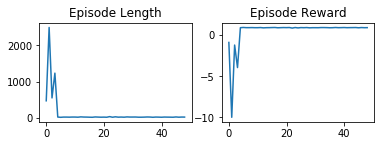

In [5]:
# plot with various axes scales
plt.figure()

# linear
plt.subplot(221)
plt.plot(stats_recorded.episode_lengths[1:100])
plt.title('Episode Length')


#plt.grid(True)


# log
plt.subplot(222)
plt.plot(stats_recorded.episode_rewards[1:100])
plt.title('Episode Reward')
#plt.grid(True)
# plt.savefig('maze q learning.png', dpi = 800)
plt.show()
